## H.4 SMC Sampler

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def target(x):
    x1, x2 = x
    # Computing pdf of unnormalized target distribution
    ind_x1 = (x1 >= 0.0) & (x1 <= 1.0) 
    ind_x2 = (x2 >= 0.0) & (x2 <= 1.0)
    return ind_x1 * ind_x2 * np.cos(x1 * np.pi)**2 * np.sin(x2 * 3 * np.pi)**6 * np.exp(-30*(x1**2 + x2**2))

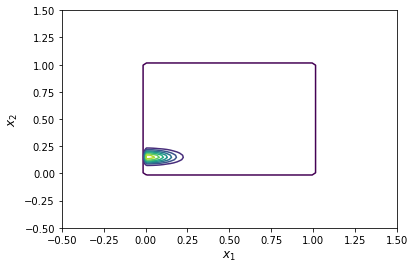

In [2]:
x = np.linspace(-.5, 1.5, 100); y = np.linspace(-.5, 1.5, 100)
X, Y = np.meshgrid(x, y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = target(x1=pos[:, :, 0], x2=pos[:, :, 1])
plt.contour(X, Y, Z)
plt.xlabel("$x_1$", fontsize=12); plt.ylabel("$x_2$", fontsize=12)
plt.show()

In [147]:
def smc_sampler(K, N, ess_trigger, tau):
    # Initialization
    x = np.zeros([K+1, N, 2])
    ancs = np.zeros([K, N], dtype=int)
    w = np.zeros([K+1, N])
    
    x[0, :, :] = multivariate_normal.rvs(mean=np.zeros(2), cov=np.eye(2), size=N)
    w[0, :] = np.ones(N) / N
    Z_k = np.zeros(K)
    Z0 = np.sqrt(2*np.pi) # since p(x0) is zero-mean Gaussian with identity matrix as covariance
    ess = np.zeros(K)
    
    for k in range(1, K+1):
        
        # Set weights
        for i in range(N):
            #w[k, i] = np.log(w[k-1, i]) + tempered_logpdf(x[k-1, i, :], k, K) - \
            #            tempered_logpdf(x[k-1, i, :], k-1, K)
            w[k, i] = w[k-1, i] * (tempered_pdf(x[k-1, i, :], k, K) / tempered_pdf(x[k-1, i, :], k-1, K))
        Z_k[k-1] = np.sum(w[k, :])
        # Normalize the weights    
        #w[k, :] -= np.max(w[k, :])
        #w[k, :] = np.exp(w[k, :]) / np.sum(np.exp(w[k, :]))
        w[k, :] = w[k, :] / np.sum(w[k, :])
        # If ESS too low, resample and set weights to 1/N
        N_ess = 1/(np.sum(w[k, :]**2 ))
        ess[k-1] = N_ess
        
        if N_ess < ess_trigger:
            ancs[k-1, :] = np.random.choice(N, size=N, p=w[k, :])
            w[k, :] = np.ones(N) / N
        else:
            ancs[k-1, :] = range(N)

        # Sample x_k from MCMC kernel
        for i in range(N):
            x[k, i, :], alpha = mcmc_kernel(x[k-1, ancs[k-1, i], :], k, K, tau)
    
    print(Z_k)
    Z_hat = Z0 * np.prod(Z_k) #np.exp(np.sum(np.log(Z_k)) + np.log(Z0))
    return x, w, ancs, Z_hat, ess

In [148]:
def log_target(x1, x2):
    ind_x1 = (x1 >= 0.0) & (x1 <= 1.0) 
    ind_x2 = (x2 >= 0.0) & (x2 <= 1.0)
    return ind_x1 * ind_x2 * (2*np.log(np.cos(x1 * np.pi)) + 
                              6 * np.log(np.sin(x2 * 3 * np.pi)) - 30*(x1**2 + x2**2) ) 

#def tempered_logpdf(x, k, K):
#    print("x: ", x)
#    return (1 - (k/K))*multivariate_normal.logpdf(x, mean=np.zeros(2), cov=np.eye(2))#(k / K) * log_target(x[0], x[1]) + 


def tempered_pdf(x, k, K):
#    print("x: ", x)
    return target(x)**(k/K) * multivariate_normal.pdf(x, mean=np.zeros(2), cov=np.eye(2))**(1-(k/K)) #(k / K) * log_target(x[0], x[1]) + 

In [149]:
def mcmc_kernel(x, k, K, tau):
    # Sample from proposal distribution
    x_prop = multivariate_normal.rvs(mean=x, cov=tau**2 * np.eye(2), size=1)
    
    # Since the proposal is a gaussian random walk, the second terms
    # in the acceptance probability will cancel out
    u = np.random.uniform(0.0, 1.0, size=1)
    
    #log_alpha = np.minimum(0.0, tempered_logpdf(x_prop, k, K) - tempered_logpdf(x, k, K))
    alpha = np.minimum(1.0, tempered_pdf(x_prop, k, K) / tempered_pdf(x, k, K))
    
    #if np.log(u) <= log_alpha:
    if u <= alpha:
        return x_prop, alpha#np.exp(log_alpha)
    else:
        return x, alpha#np.exp(log_alpha)

In [150]:
np.random.seed(42)
N = 100
tau = 1.0#0.02
ess_trigger = 0.7*N
K = 10
x, w, ancs, Z_hat, ess = smc_sampler(K, N, ess_trigger, tau)
print("Estimate of normalizing constant: ", Z_hat)

[0.02444236 0.45199247 0.6181407  0.73387296 0.82840232 0.9046287
 0.95431224 0.99483683 1.02222183 1.0396102 ]
Estimate of normalizing constant:  0.009498218673013288


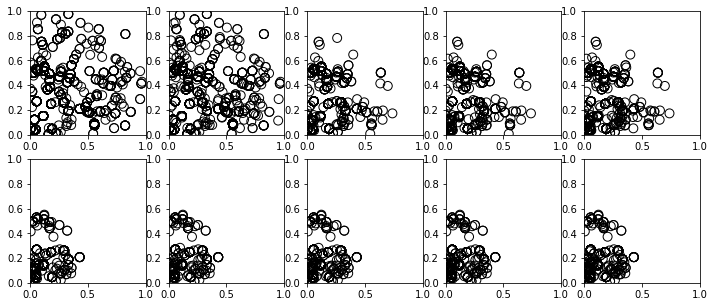

In [151]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12,5))
axs = axs.flatten()
for k in range(K):
    #print(axs[k])
    axs[k].scatter(x[k+1, :, 0], x[k+1, :, 1], s=80, facecolors='none', edgecolors='k')
    axs[k].set_xlim(0.0, 1.0); axs[k].set_ylim(0.0, 1.0); 

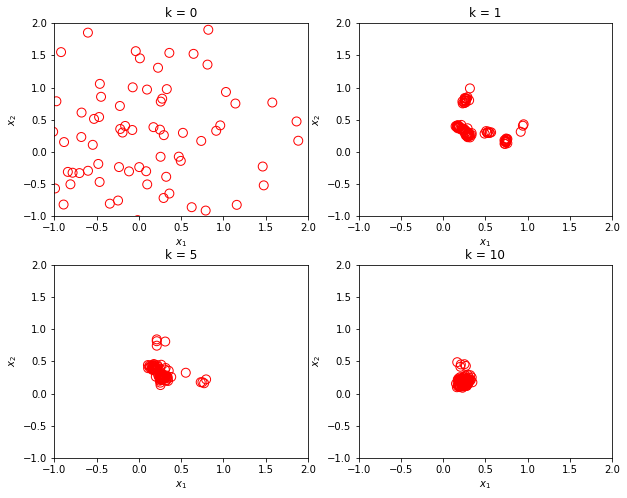

In [118]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
plt.subplots_adjust(hspace=0.25)
axs = axs.flatten()
ks = [0, 1, 5, 10]
for i, k in enumerate(ks):
    #print(axs[k])
    axs[i].scatter(x[k, :, 0], x[k, :, 1], s=80, facecolors='none', edgecolors='r')
    axs[i].set_xlim(-1.0, 2.0); axs[i].set_ylim(-1.0, 2.0); 
    axs[i].set_xlabel("$x_1$"); axs[i].set_ylabel("$x_2$")
    axs[i].set_title("k = {:d}".format(k))

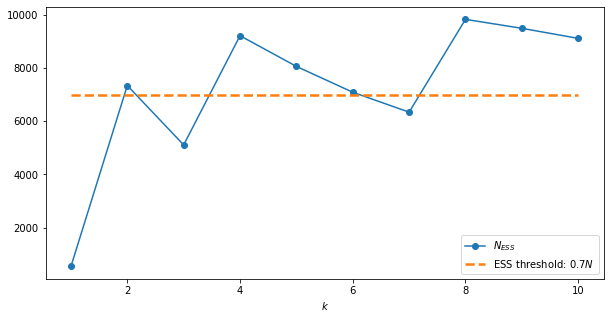

In [136]:
# Plot of N_ESS over time step k
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.linspace(1, K, K), ess, '-o', label="$N_{ESS}$")
ax.plot(np.linspace(1, K, K+1), 0.7*N*np.ones(K+1), '--',
        label=r"ESS threshold: $0.7N$", linewidth=2.5)
ax.set_xlabel("$k$")#; ax.set_ylabel()
ax.legend(loc="lower right")
plt.show()

In [143]:
# Sanity check with importance sampling
def importance_sampling(N=1000):
    x = multivariate_normal.rvs(mean=np.zeros(2), cov=np.eye(2), size=N)
    w = np.zeros(N)
    for i in range(N):
        w[i] = target(x[i, :]) / multivariate_normal.pdf(x[i, :], mean=np.zeros(2), cov=np.eye(2))
    return w

np.random.seed(42)
weights = importance_sampling(N=1000)
print("Estimate of normalizing constant: ", np.mean(weights))

Estimate of normalizing constant:  0.004081594114887974
